In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  accuracy_score

In [146]:
#  ファイルの読み込み]
DATA_HOME_DIR = "./raw/"
train = pd.read_csv(DATA_HOME_DIR + 'train.csv')
test = pd.read_csv(DATA_HOME_DIR + 'test.csv')
gender_submission = pd.read_csv(DATA_HOME_DIR + 'gender_submission.csv')

前処理

In [147]:
# 前処理のためにtrainとtestを連結
train['is_test'] = 0
train['is_train'] = 1
test['is_test'] = 1 
test['is_train'] = 0

# 目的変数
Y = train['Survived']
train_X = train.drop(['Survived'], axis = 1)

# テストID
test_id = test['PassengerId']
test_X = test

# 連結
all_df = pd.concat([train_X, test_X], axis=0)

In [148]:
# 欠損値}
all_df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
is_test           0
is_train          0
dtype: int64

In [149]:
# Age欠損値処理
# 男女別でPclass毎の中央値で埋め
# all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mean())   # 平均値
# all_df['Age'] = all_df['Age'].fillna(all_df['Age'].median()) # 中央値
# all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mode())   # 最頻値

m1 = all_df[(all_df['Sex'] == 'male') & (all_df['Pclass'] == 1)]['Age'].median()
m2 = all_df[(all_df['Sex'] == 'male') & (all_df['Pclass'] == 2)]['Age'].median()
m3 = all_df[(all_df['Sex'] == 'male') & (all_df['Pclass'] == 3)]['Age'].median()
f1 = all_df[(all_df['Sex'] == 'female') & (all_df['Pclass'] == 1)]['Age'].median()
f2 = all_df[(all_df['Sex'] == 'female') & (all_df['Pclass'] == 2)]['Age'].median()
f3 = all_df[(all_df['Sex'] == 'female') & (all_df['Pclass'] == 3)]['Age'].median()

all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'male') & (all_df['Pclass'] == 1),  'Age'] = m1
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'male') & (all_df['Pclass'] == 2),  'Age'] = m2
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'male') & (all_df['Pclass'] == 3),  'Age'] = m3
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'female') & (all_df['Pclass'] == 1),  'Age'] = f1
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'female') & (all_df['Pclass'] == 2),  'Age'] = f2
all_df.loc[(all_df['Age'].isnull()) & (all_df['Sex'] == 'female') & (all_df['Pclass'] == 3),  'Age'] = f3

In [150]:
# Fare欠損値確認
all_df[all_df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,0


In [151]:
# Fare欠損値処理
# Pcalass=3の平均値で埋め
Pclass3mean = all_df[all_df['Pclass'] == 3]['Fare'].mean()
all_df['Fare'].fillna(Pclass3mean, inplace=True) 

In [152]:
all_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1
5,6,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q,0,1
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,1
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,1
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,1
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0,1


In [153]:
# Embarked欠損値確認
all_df[all_df['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,1
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,1


In [154]:
# pclass=1の人が割合が一番多いCで埋める
all_df['Embarked'].fillna('C', inplace=True) 

In [155]:
all_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test,is_train
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


In [156]:
#  Ageのカテゴリ変数化
# all_df.loc[ all_df['Age']  <=  10,  'Age_c']  =  0
# all_df.loc[(all_df['Age'] >  10)  &  (all_df['Age']  <=  20),  'Age_c']  =  1
# all_df.loc[(all_df['Age'] >  40)  &  (all_df['Age']  <=  30),  'Age_c']  =  2
# all_df.loc[(all_df['Age'] >  30)  &  (all_df['Age']  <=  40),  'Age_c']  =  3
# all_df.loc[(all_df['Age'] >  40)  &  (all_df['Age']  <=  50),  'Age_c']  =  4
# all_df.loc[(all_df['Age'] >  50)  &  (all_df['Age']  <=  60),  'Age_c']  =  5
# all_df.loc[(all_df['Age'] >  60)  &  (all_df['Age']  <=  70),  'Age_c']  =  6
# all_df.loc[(all_df['Age'] >  70)  &  (all_df['Age']  <=  80),  'Age_c']  =  7
# all_df.loc[ all_df['Age']  >  80,  'Age_c']    =  8

In [157]:
all_df.drop(['Name', 'Cabin', 'Ticket'],  axis=1,  inplace=True)

In [158]:
# カテゴリ変数を取得する関数
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# カテゴリ変数をファクトライズ (整数に置換)する関数
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# カテゴリ変数のダミー変数 (二値変数化)を作成する関数
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

In [159]:
# カテゴリ変数を取得
all_df_cats = _get_categorical_features(all_df)
all_df_cats

['Sex', 'Embarked']

In [160]:
# ダミー変数を取得
all_df = _get_dummies(all_df, all_df_cats)
all_df.drop(all_df_cats,  axis=1,  inplace=True)
all_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,is_test,is_train,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,3,22.0,1,0,7.2500,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,0,1,1,0,1,0,0
2,3,3,26.0,0,0,7.9250,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,0,1,1,0,0,0,1
4,5,3,35.0,0,0,8.0500,0,1,0,1,0,0,1


In [161]:
# 最終的なtrainとtestデータを用意
ignore_features = ['PassengerId', 'is_train', 'is_test']
relevant_features = [col for col in all_df.columns if col not in ignore_features]
trainX = all_df[all_df['is_train'] == 1][relevant_features]
testX = all_df[all_df['is_test'] == 1][relevant_features]

In [162]:
from sklearn.model_selection import train_test_split 
x_train, x_val, y_train, y_val = train_test_split(trainX, Y, test_size=0.3, random_state=18)
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [163]:
from sklearn.model_selection import KFold

#  3分割交差検証を指定し、インスタンス化
kf  =  KFold(n_splits=3)
params  =  {
    'objective':  'binary',
    'learning_rate':  0.1,
    'num_leaves'  :  300
}

# kf.split(X_train.Ytrain)で、X_trainとY_trainを3分割し、交差検証をする
for  train_index,  test_index  in kf.split(trainX, Y):
    X_cv_train  = trainX.iloc[train_index]
    X_cv_test  = trainX.iloc[test_index]
    Y_cv_train  =  Y[train_index]
    Y_cv_test  =  Y[test_index]

    #  識別機を作成
    gbm  =  lgb.LGBMClassifier(objective='binary',
        num_leaves  =  300,
        learning_rate  =  0.1,
        )

    #  学習
    gbm.fit(X_cv_train, Y_cv_train,
    eval_set  =  [(X_cv_test,  Y_cv_test)],
    early_stopping_rounds=10,)

    #  予測し精度を表示
    Y_pred  = gbm.predict(X_cv_test,num_iteration=gbm.best_iteration_)
    print(round(accuracy_score(Y_cv_test,Y_pred)*100,2))

[1]	valid_0's binary_logloss: 0.622051
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.59518
[3]	valid_0's binary_logloss: 0.575372
[4]	valid_0's binary_logloss: 0.555782
[5]	valid_0's binary_logloss: 0.541353
[6]	valid_0's binary_logloss: 0.528611
[7]	valid_0's binary_logloss: 0.520366
[8]	valid_0's binary_logloss: 0.511644
[9]	valid_0's binary_logloss: 0.506954
[10]	valid_0's binary_logloss: 0.500128
[11]	valid_0's binary_logloss: 0.494467
[12]	valid_0's binary_logloss: 0.490664
[13]	valid_0's binary_logloss: 0.487002
[14]	valid_0's binary_logloss: 0.48421
[15]	valid_0's binary_logloss: 0.48116
[16]	valid_0's binary_logloss: 0.480345
[17]	valid_0's binary_logloss: 0.479114
[18]	valid_0's binary_logloss: 0.477571
[19]	valid_0's binary_logloss: 0.476075
[20]	valid_0's binary_logloss: 0.472902
[21]	valid_0's binary_logloss: 0.473093
[22]	valid_0's binary_logloss: 0.473338
[23]	valid_0's binary_logloss: 0.473549
[24]	valid_0's binary_logloss:

C:\Users\naofumi_honda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\naofumi_honda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\naofumi_honda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


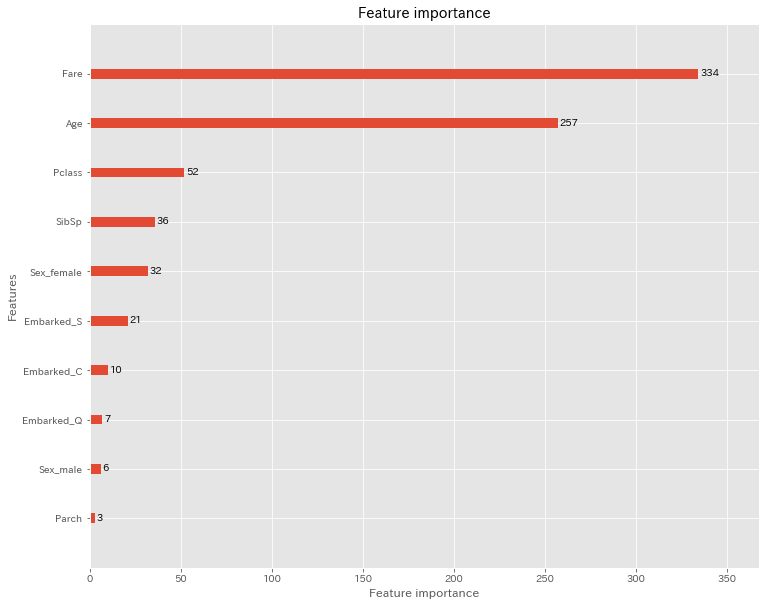

In [164]:
lgb.plot_importance(gbm, figsize=(12, 10));

In [165]:
gbm.fit(trainX, Y)
# 予測
pred = gbm.predict(testX)
# 提出用
gender_submission["Survived"] = pred
gender_submission.to_csv('./submit/submit_lgbm03.csv',index=None)

C:\Users\naofumi_honda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
